In [29]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
# from imblearn.over_sampling import SMOTE

# Load the dataset
df = pd.read_csv('titanic_data.csv')

# Feature engineering: Extract title from the "Name" column
df['Title'] = df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)


# Split data into attributes and target
attributes = df.drop('Survived', axis=1)
target = df['Survived']

# Identify numerical and categorical columns
numeric_features = attributes.select_dtypes(include=['int64', 'float64']).columns
categorical_features = attributes.select_dtypes(include=['object']).columns

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Define the model
knn_model = KNeighborsClassifier(n_neighbors=5)

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', knn_model)
])

# Split data into training and testing sets
xtrain, xtest, ytrain, ytest = train_test_split(attributes, target, test_size=0.3, random_state=42)


# Apply SMOTE to handle the imbalanced data
# smote = SMOTE(random_state=42)
# xtrain_resampled, ytrain_resampled = smote.fit_resample(xtrain, ytrain)

# Fit the pipeline
pipeline.fit(xtrain, ytrain)







Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Title'], dtype='object'))])),
                ('classifier', KNeighborsClassifier())])

In [20]:
# Evaluate the model
accuracy = pipeline.score(xtest, ytest)
print(f"Accuracy on test set: {accuracy:.2f}")


Accuracy on test set: 0.82


In [15]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(ytest, pipeline.predict(xtest))
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.91      0.85       157
           1       0.84      0.68      0.76       111

    accuracy                           0.82       268
   macro avg       0.82      0.80      0.80       268
weighted avg       0.82      0.82      0.81       268



Accuracy on test set: 0.82


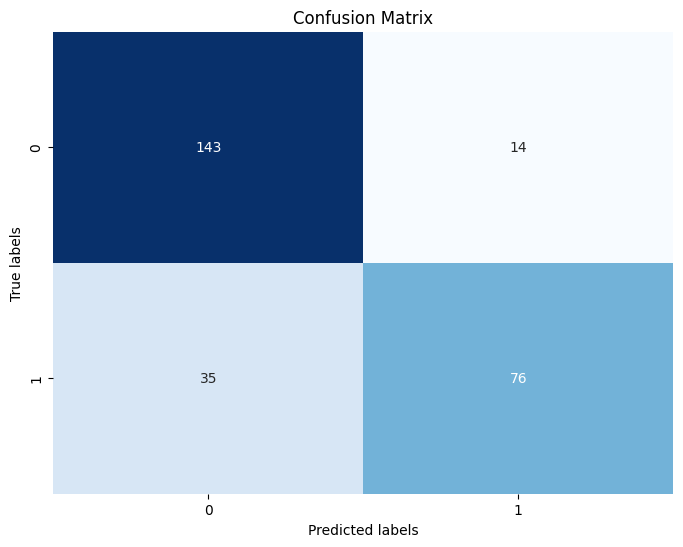

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming 'pipeline' is your trained model
# Evaluate the model
accuracy = pipeline.score(xtest, ytest)
print(f"Accuracy on test set: {accuracy:.2f}")

# Calculate the predictions
predictions = pipeline.predict(xtest)

# Calculate confusion matrix
conf_matrix = confusion_matrix(ytest, predictions)

# Visualize confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

